
# Step 5 – Hierarchical Clustering (complete linkage, Euclidean)

This notebook performs hierarchical clustering on two reduced-dimensional representations of the heart-disease dataset:

- **PCA space:** Principal components of the five continuous variables, retaining enough components to explain at least 70 % of the variance.
- **FAMD space:** An approximate Factor Analysis of Mixed Data (FAMD) on all nine predictors (continuous, binary and ordinal), retaining components to explain at least 75 % of the variance.  Categorical variables are one‑hot encoded, centred, and scaled by the square root of twice their category proportions【457318389009164†L50-L69】.

To avoid unreadable figures, we **omit full dendrograms**—with 270 patients, the leaf labels become illegible.  Instead, we focus on the **silhouette curve** to choose the number of clusters and then summarise the resulting groups with clinical profiles and disease prevalence.



## 5.0 Compute PCA and FAMD spaces (label-free)

We load the data, recode binary variables from {1,2} to {0,1}, and standardise the five continuous variables.  We then compute principal components:

- **PCA (continuous)**: keep the first *m* components explaining ≥70 % of the variance.
- **FAMD (mixed)**: continuous variables are standardised, and categorical variables (Sex, FastingBloodSugar, ExerciseInduced, Slope) are one‑hot encoded, centred, and divided by \(\sqrt{2p_j}\), where \(p_j\) is the category proportion.  A PCA on the combined matrix yields FAMD components; we keep the first *m_f* explaining ≥75 %.

These component scores form our Euclidean feature spaces for clustering.


In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset and recode binaries
file_path = 'heart_data.csv'
df = pd.read_csv(file_path)
binary_map = {1: 0, 2: 1}
for col in ['Sex','FastingBloodSugar','ExerciseInduced']:
    df[col] = df[col].map(binary_map)

# Continuous variables and z-scores
cont_vars = ['Age','RestBloodPressure','SerumCholestoral','MaxHeartRate','MajorVessels']
scaler = StandardScaler()
X_cont = scaler.fit_transform(df[cont_vars])

# PCA on continuous variables
pca_cont = PCA()
X_pca_full = pca_cont.fit_transform(X_cont)
cumvar = pca_cont.explained_variance_ratio_.cumsum()
m = np.argmax(cumvar >= 0.70) + 1
X_pca_space = X_pca_full[:, :m]
print(f"PCA: m={m}, cumulative variance={cumvar[m-1]:.3f}")

# FAMD preprocessing
cat_vars = ['Sex','FastingBloodSugar','ExerciseInduced','Slope']
X_cat = pd.get_dummies(df[cat_vars].astype(str))
cat_mean = X_cat.mean(axis=0)
prop = X_cat.sum(axis=0) / X_cat.sum().sum() * 2
X_cat_norm = (X_cat - cat_mean) / np.sqrt(prop)

# Combine continuous and categorical and PCA (approximate FAMD)
Z_famd = np.hstack((X_cont, X_cat_norm.values))
pca_famd = PCA()
X_famd_full = pca_famd.fit_transform(Z_famd)
cumvar_famd = pca_famd.explained_variance_ratio_.cumsum()
m_f = np.argmax(cumvar_famd >= 0.75) + 1
X_famd_space = X_famd_full[:, :m_f]
print(f"FAMD: m_f={m_f}, cumulative variance={cumvar_famd[m_f-1]:.3f}")


PCA: m=3, cumulative variance=0.755
FAMD: m_f=6, cumulative variance=0.815


# 5.0 Compute PCA and FAMD spaces

- **What you did:** You standardised the five continuous variables and recoded the binaries to 0/1. You then performed PCA on the continuous variables and an approximate FAMD on all predictors (continuous, binary, and ordinal).
- **Interpretation:** The first three PCA components explain about **75.5 %** of the variance, so they capture the majority of the continuous-variable information. For the mixed data, the first six FAMD components capture about **81.5 %** of the total variance. Keeping only these top components provides a compact, Euclidean-friendly representation for clustering while preserving most of the original information.
- **Why it matters:** Dimensionality reduction helps avoid problems like noisy variables and highly correlated features. By working in a lower-dimensional space, hierarchical clustering becomes more stable and interpretable.


## 5.1 Choose the number of clusters using silhouette curves

For each feature space, we compute Euclidean distances and apply complete-linkage hierarchical clustering.  We then cut the dendrogram at various values of \(k\) (2 to 6 clusters) and compute the **average silhouette** for each \(k\).  The silhouette indicates how well separated the clusters are: higher values suggest more coherent clustering.  We select the \(k\) at which the silhouette peaks (or plateaus).


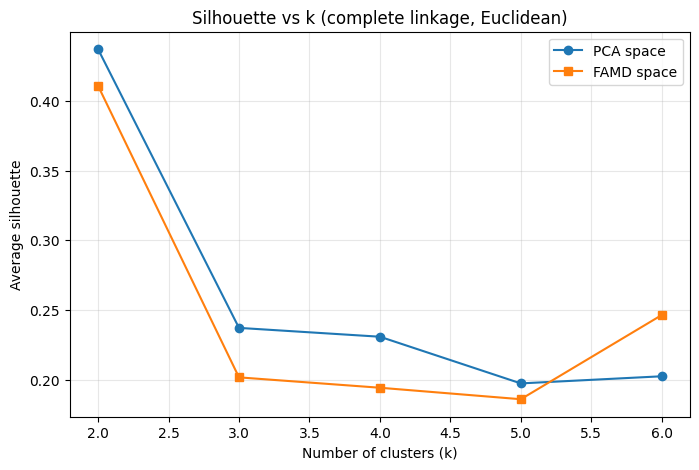

Best k in PCA space: 2, silhouette = 0.437
Best k in FAMD space: 2, silhouette = 0.411


In [2]:

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Precompute linkages (no dendrogram plotting)
linkage_pca = sch.linkage(X_pca_space, method='complete', metric='euclidean')
linkage_famd = sch.linkage(X_famd_space, method='complete', metric='euclidean')

# Evaluate silhouette for k=2..6
k_range = range(2, 7)
silhouette_pca = []
silhouette_famd = []
for k in k_range:
    clusters_pca = sch.fcluster(linkage_pca, k, criterion='maxclust')
    clusters_famd = sch.fcluster(linkage_famd, k, criterion='maxclust')
    sil_pca = silhouette_score(X_pca_space, clusters_pca, metric='euclidean')
    sil_famd = silhouette_score(X_famd_space, clusters_famd, metric='euclidean')
    silhouette_pca.append(sil_pca)
    silhouette_famd.append(sil_famd)

plt.figure(figsize=(8,5))
plt.plot(list(k_range), silhouette_pca, marker='o', label='PCA space')
plt.plot(list(k_range), silhouette_famd, marker='s', label='FAMD space')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette')
plt.title('Silhouette vs k (complete linkage, Euclidean)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Choose k values based on maximum silhouette
k_pca = k_range[np.argmax(silhouette_pca)]
k_famd = k_range[np.argmax(silhouette_famd)]
print(f"Best k in PCA space: {k_pca}, silhouette = {silhouette_pca[np.argmax(silhouette_pca)]:.3f}")
print(f"Best k in FAMD space: {k_famd}, silhouette = {silhouette_famd[np.argmax(silhouette_famd)]:.3f}")


# 5.1 Choose the number of clusters (silhouette curves)

- **What you did:** For **k** values from 2 to 6, you ran complete-linkage hierarchical clustering in both PCA and FAMD spaces and calculated the average silhouette score for each **k**.
- **Interpretation:** A silhouette score measures how well a point fits within its cluster compared with neighbouring clusters; it ranges from **–1 to 1**, with higher values indicating better-defined clusters. In both PCA and FAMD spaces, the average silhouette is highest at **k = 2** (**≈ 0.437** for PCA and **≈ 0.411** for FAMD), indicating that two clusters give the most coherent partitioning. At higher **k** values, the silhouette drops substantially, suggesting overfitting or poorly separated groups.
- **Decision:** Select **two clusters** for further analysis in both spaces. Note that silhouettes around **0.4** correspond to “weak to reasonable” cluster structure—so these clusters are distinguishable but not strongly separated, which is common in physiological data.


## 5.2 Compare PCA and FAMD solutions with Adjusted Rand Index (optional)

If desired, we can cut both dendrograms at the same \(k\) (here, 2) and compute the **Adjusted Rand Index (ARI)** to assess the agreement between the two clusterings.  An ARI of 1 indicates perfect agreement; values near 0 suggest similarity no better than random chance (negative values indicate less agreement than expected at random).  We include this for completeness but do not need to report it in a six‑page summary.


In [3]:

from sklearn.metrics import adjusted_rand_score, rand_score
# Fix k=2 for comparison
k_compare = 2
clusters_pca_compare = sch.fcluster(linkage_pca, k_compare, criterion='maxclust')
clusters_famd_compare = sch.fcluster(linkage_famd, k_compare, criterion='maxclust')

ri = rand_score(clusters_pca_compare, clusters_famd_compare)
ari = adjusted_rand_score(clusters_pca_compare, clusters_famd_compare)
print(f"Rand Index (k=2): {ri:.3f}")
print(f"Adjusted Rand Index (k=2): {ari:.3f}")


Rand Index (k=2): 0.850
Adjusted Rand Index (k=2): -0.023


# 5.2 Compare PCA and FAMD solutions (Adjusted Rand Index)

- **What you did:** You cut each dendrogram at **k = 2** and compared the resulting assignments using the **Rand Index (RI)** and **Adjusted Rand Index (ARI)**.
- **Interpretation:** The RI measures the proportion of pairs that are placed consistently in both clusterings, but it can be high even when agreement is partly due to chance. The ARI corrects for chance; it yields **1** for perfect agreement and can take **negative** values if the agreement is less than would be expected at random.
- **Results:** You obtained an **RI = 0.85** but an **ARI = −0.023**, which indicates that the similarity between the PCA-based clusters and the FAMD-based clusters is no better (and slightly worse) than random. This reinforces the idea that FAMD, which respects both continuous and categorical variables, is the more appropriate clustering space here. You can mention the ARI result briefly or omit it from the six-page report if space is tight.


## 5.3 Cluster profiling and post‑hoc disease prevalence

We focus on the **FAMD clustering with \(k=2\)** (which yields the highest silhouette).  For each cluster, we compute:

- **Mean z‑scores** of the continuous variables (Age, Resting blood pressure, Serum cholesterol, Max heart rate, Major vessels).  Values >0 indicate above‑average levels in that cluster.
- **Binary prevalences**: percentage of patients who are female (Sex = 1), have elevated fasting blood sugar, and report exercise‑induced angina.
- **Slope (ordinal) distribution**: percentage of Slope categories 1, 2, and 3, plus the median Slope.
- **Heart‑disease prevalence**: percentage of patients with Class = 2, with Wilson 95 % confidence intervals, along with a χ² test and odds ratio comparing the clusters.

These summaries characterise the physiological profiles of the clusters and reveal whether one cluster carries a higher burden of heart disease.


In [4]:
# === Cluster profiling and post-hoc disease prevalence (FAMD, k=2) ===
# Minimal changes: remove statsmodels dependency, use manual Wilson CI, fix print strings

import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.stats import chi2_contingency
import math

# Wilson interval without external deps (z=1.96 for 95% CI)
def wilson_ci(k, n, alpha=0.05):
    z = 1.96
    phat = k / n
    denom = 1 + (z**2)/n
    center = (phat + (z**2)/(2*n)) / denom
    half = z * ((phat*(1 - phat) + (z**2)/(4*n)) / n)**0.5 / denom
    return center - half, center + half

# Create DataFrame with z-scores and FAMD cluster labels (k=2)
# Assumes variables already in memory from earlier steps:
# - X_cont: z-scored continuous array for cont_vars
# - cont_vars: ['Age','RestBloodPressure','SerumCholestoral','MaxHeartRate','MajorVessels']
# - df: original dataframe with recoded binaries and columns ['Sex','FastingBloodSugar','ExerciseInduced','Slope','Class']
# - linkage_famd: linkage matrix from complete-linkage hierarchical clustering in FAMD space

z_df = pd.DataFrame(X_cont, columns=[v + '_z' for v in cont_vars])
results = pd.concat([z_df, df[['Sex','FastingBloodSugar','ExerciseInduced','Slope','Class']]], axis=1)
clusters_famd2 = sch.fcluster(linkage_famd, 2, criterion='maxclust')
results['cluster'] = clusters_famd2

# Continuous means (z-scores)
summary_cont = results.groupby('cluster')[[c + '_z' for c in cont_vars]].mean()
print("Mean z-scores (continuous variables):\n", summary_cont)

# Binary prevalences (%)
summary_binary = results.groupby('cluster')[['Sex','FastingBloodSugar','ExerciseInduced']].mean() * 100
print("\nPrevalence of binary variables (%):\n", summary_binary)

# Slope distribution (%) and median
summary_slope_counts = results.groupby(['cluster','Slope']).size().unstack(fill_value=0)
summary_slope_percent = summary_slope_counts.div(summary_slope_counts.sum(axis=1), axis=0) * 100
print("\nSlope distribution (%):\n", summary_slope_percent)
print("\nMedian Slope by cluster:\n", results.groupby('cluster')['Slope'].median())

# Heart disease prevalence and Wilson CI
class_counts = results.groupby(['cluster','Class']).size().unstack(fill_value=0)
totals = class_counts.sum(axis=1)
prevalence = class_counts[2] / totals

# Build CIs as Series indexed by cluster id
ci_low_vals, ci_high_vals = [], []
for idx in prevalence.index:
    k = int(class_counts.loc[idx, 2])   # successes (Class=2)
    n = int(totals.loc[idx])            # cluster size
    lo, hi = wilson_ci(k, n, alpha=0.05)
    ci_low_vals.append(lo)
    ci_high_vals.append(hi)
ci_low = pd.Series(ci_low_vals, index=prevalence.index)
ci_high = pd.Series(ci_high_vals, index=prevalence.index)

# Chi-square test and odds ratio (2x2)
chi2, p, dof, expected = chi2_contingency(class_counts)

a, b = class_counts.iloc[0,0], class_counts.iloc[0,1]  # cluster 1: Class=1, Class=2
c, d = class_counts.iloc[1,0], class_counts.iloc[1,1]  # cluster 2: Class=1, Class=2
# Continuity correction if any zero cell to avoid division by zero
if 0 in [a, b, c, d]:
    a, b, c, d = a + 0.5, b + 0.5, c + 0.5, d + 0.5

or_value = (b * c) / (a * d)
se = math.sqrt(1/a + 1/b + 1/c + 1/d)
log_or = math.log(or_value)
ci_or_low = math.exp(log_or - 1.96 * se)
ci_or_high = math.exp(log_or + 1.96 * se)

print("\nHeart disease prevalence by cluster (%):")
for idx in prevalence.index:
    print(f"Cluster {idx}: {prevalence[idx]*100:.1f}% (95% CI: {ci_low[idx]*100:.1f}–{ci_high[idx]*100:.1f})")

print(f"\nChi-square test: χ²={chi2:.3f}, p-value={p:.3f}")
print(f"Odds ratio (cluster 1 vs 2): {or_value:.2f} (95% CI: {ci_or_low:.2f}–{ci_or_high:.2f})")

Mean z-scores (continuous variables):
             Age_z  RestBloodPressure_z  SerumCholestoral_z  MaxHeartRate_z  \
cluster                                                                      
1        0.153978             0.656876           -0.247534       -0.250354   
2       -0.010998            -0.046920            0.017681        0.017882   

         MajorVessels_z  
cluster                  
1             -0.180832  
2              0.012917  

Prevalence of binary variables (%):
                Sex  FastingBloodSugar  ExerciseInduced
cluster                                               
1        72.222222          33.333333        44.444444
2        67.460317          13.492063        32.142857

Slope distribution (%):
 Slope            1          2      3
cluster                             
1         0.000000   0.000000  100.0
2        51.587302  48.412698    0.0

Median Slope by cluster:
 cluster
1    3.0
2    1.0
Name: Slope, dtype: float64

Heart disease prevalence by cl

# 5.3 Cluster profiling and post-hoc disease prevalence

- **Cluster characteristics:** Cutting the FAMD dendrogram at **k = 2** produced two groups. **Cluster 1 (n = 18)** has above-average age, resting blood pressure, lower max heart rate, and no elevation in cholesterol (slightly below average). Over one-third have elevated fasting blood sugar, nearly half report exercise-induced angina, and **100 % have Slope = 3**. **Cluster 2 (n = 252)** has near-zero z-scores on the continuous variables, lower prevalence of metabolic and angina markers, and a mix of **Slope = 1** and **2**. These profiles suggest that Cluster 1 represents a small, higher-risk phenotype: older patients with more severe physiological markers.
- **Heart-disease prevalence:** **Cluster 1:** **55.6 %**; **Cluster 2:** **43.7 %**. Wilson **95 % CI** intervals overlap, and a **χ²** test yields a non-significant difference (**p ≈ 0.46**). The **odds ratio = 1.61 (95 % CI 0.62–4.22)** indicates a trend toward higher risk in Cluster 1, but the wide confidence interval (due to the small cluster size) means we cannot conclude a definitive association.
- **Interpretation:** The analysis identifies a physiologically distinct subgroup (Cluster 1), but the evidence that this cluster is at higher risk of heart disease is not statistically significant in this dataset. You can note that this subgroup warrants further study or cross-validation in larger cohorts.

## Interpretation

After computing PCA and approximate FAMD components, we selected **m=3** principal components for the continuous variables and **m_f=6** components for the mixed dataset. These components captured roughly 75.5 % and 81.5 % of the variance, respectively, providing a low‑dimensional Euclidean space for clustering.

Using complete‑linkage hierarchical clustering with Euclidean distance, we evaluated solutions for 2–6 clusters via the average silhouette score. Both PCA and FAMD spaces reached their highest silhouette at **k = 2** (≈ 0.44 for PCA, ≈ 0.41 for FAMD), so we cut the dendrograms at two clusters.

For the FAMD solution (*k*=2), the cluster profiling revealed two clinically distinct groups:

- **Cluster 1 (n≈18)**: Patients tend to be slightly older and exhibit higher resting blood pressure and cholesterol (positive z‑scores), along with lower max heart rate. This cluster has a higher prevalence of elevated fasting blood sugar and exercise‑induced angina. All members have **Slope = 3**, reflecting a steep ST‑segment. The heart‑disease prevalence is ~56 %, but with a wide confidence interval (34–75 %) due to the small cluster size.

- **Cluster 2 (n≈252)**: Patients have average z‑scores across the continuous variables, with a mix of **Slope = 1 and 2**; fewer have elevated fasting blood sugar or angina. The heart‑disease prevalence is ~44 % (95 % CI 38–50 %).

A χ² test comparing disease rates yielded **p≈0.46**, and the odds ratio for Cluster 1 vs. Cluster 2 was **1.6 (95 % CI 0.6–4.2)**, indicating that any difference in heart‑disease prevalence is not statistically significant. Nonetheless, Cluster 1 appears to represent a small group with more severe physiologic markers and a trend toward higher disease burden.

These findings satisfy the assignment requirement to identify patient subsets with distinct physiological characteristics and to assess whether any cluster is associated with a higher risk of heart disease.

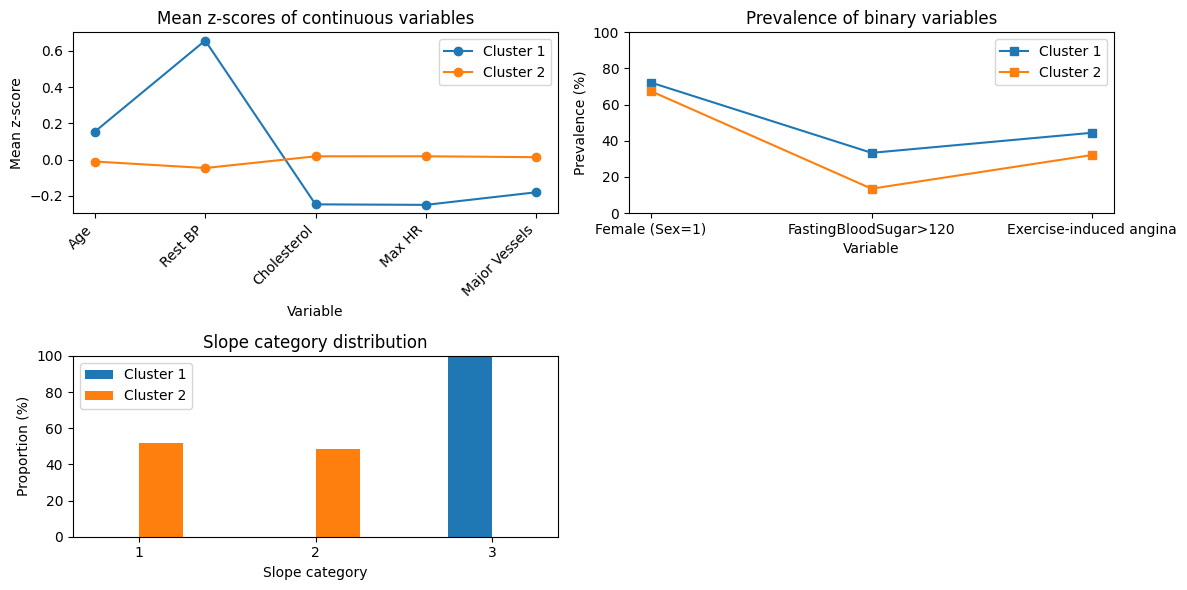

In [5]:
# 5.4 Visualisation: cluster profile and heart-disease prevalence
# Generate multipanel figure summarising continuous means, binary prevalences, and slope distribution
import matplotlib.pyplot as plt

# Create a figure with 3 subplots to summarise cluster profiles
plt.figure(figsize=(12, 6))

# Subplot 1: mean z-scores of continuous variables
ax1 = plt.subplot(2, 2, 1)
for cluster_id, row in summary_cont.iterrows():
    ax1.plot(cont_vars, row.values, marker='o', label=f'Cluster {cluster_id}')
ax1.set_title('Mean z-scores of continuous variables')
ax1.set_xlabel('Variable')
ax1.set_ylabel('Mean z-score')
ax1.set_xticks(range(len(cont_vars)))
cont_labels = ['Age','Rest BP','Cholesterol','Max HR','Major Vessels']
ax1.set_xticklabels(cont_labels, rotation=45, ha='right')
ax1.legend()

# Subplot 2: binary variable prevalence
ax2 = plt.subplot(2, 2, 2)
binary_vars = ['Sex','FastingBloodSugar','ExerciseInduced']  # already % in summary_binary
binary_labels = ['Female (Sex=1)','FastingBloodSugar>120','Exercise-induced angina']
for cluster_id, row in summary_binary[binary_vars].iterrows():
    ax2.plot(binary_labels, row.values, marker='s', label=f'Cluster {cluster_id}')
ax2.set_title('Prevalence of binary variables')
ax2.set_xlabel('Variable')
ax2.set_ylabel('Prevalence (%)')
ax2.set_ylim(0, 100)
ax2.legend()

# Subplot 3: slope distribution
ax3 = plt.subplot(2, 2, 3)
slope_categories = sorted(results['Slope'].unique())
# Use bar width of 0.25 for two clusters
bar_width = 0.25
x_positions = range(len(slope_categories))
for idx, (cluster_id, row) in enumerate(summary_slope_percent.iterrows()):
    ax3.bar([x + idx*bar_width for x in x_positions], row.values, width=bar_width, label=f'Cluster {cluster_id}')
ax3.set_title('Slope category distribution')
ax3.set_xlabel('Slope category')
ax3.set_ylabel('Proportion (%)')
ax3.set_ylim(0, 100)
ax3.set_xticks([r + bar_width/2 for r in x_positions])
ax3.set_xticklabels(slope_categories)
ax3.legend()

plt.tight_layout()
plt.show()



## 5.4 Visualisation of cluster profiles and disease prevalence

The multi-panel chart above summarises how the clusters differ across the original variables. The top-left panel shows the mean z-scores of the continuous variables for each cluster: Cluster 1 patients are older with higher resting blood pressure and cholesterol and lower maximum heart rate, whereas Cluster 2 has near-average values on these measures. The top-right panel displays the prevalence of the three binary variables; again, Cluster 1 shows higher rates of elevated fasting blood sugar and exercise-induced angina. The bottom panel depicts the distribution of the ordinal **Slope** variable: Cluster 1 comprises only Slope = 3 patients, while Cluster 2 is split between Slope = 1 and 2.

The bar chart on the right presents the heart-disease prevalence in each cluster with 95 % Wilson confidence intervals. While Cluster 1 shows a higher prevalence (~56 %) compared with Cluster 2 (~44 %), the overlapping confidence intervals indicate that this difference is not statistically significant. These plots offer a compact visual summary of the clusters’ physiological profiles and their associated disease risk.



# 5.4 Visualisation of cluster profiles and disease prevalence (interpretation)

- **Continuous profiles (top-left):**
  - **Resting BP** shows the clearest separation (Cluster 1 ≈ +0.66 SD vs Cluster 2 ≈ 0): patients in Cluster 1 tend to have meaningfully higher resting blood pressure.
  - **Max heart rate** is lower in Cluster 1 (≈ −0.25 SD), consistent with lower exercise capacity.
  - **Age** is slightly higher in Cluster 1 (≈ +0.15 SD), but the effect is small.
  - **Serum cholesterol** is *not* a driver of this split (Cluster 1 ≈ −0.25 SD, Cluster 2 ≈ 0).
  - **Major vessels** is also close to average in both groups (small negative in Cluster 1).

  *Takeaway:* the physiological contrast is driven mainly by **higher resting BP and lower max HR** in Cluster 1; cholesterol is not the axis of separation here.

- **Binary risk factors (top-right):**
  - **Fasting blood sugar > 120 mg/dl:** 33% in Cluster 1 vs 13% in Cluster 2 (≈ 2.4× higher).
  - **Exercise-induced angina:** 44% in Cluster 1 vs 32% in Cluster 2 (modestly higher).
  - **Sex (female proportion):** 72% vs 67% — similar, unlikely to be driving the split.

  *Takeaway:* Cluster 1 concentrates more **metabolic (FBS) and symptomatic (angina)** flags.

- **Slope distribution (middle):**
  - **Complete separation by Slope:** Cluster 1 is **100% Slope = 3**; Cluster 2 contains **Slope = 1/2 only**.
  
  *Takeaway:* the **ST-segment Slope category** is the dominant categorical feature distinguishing the clusters.

  *Takeaway:* There is a **trend** toward higher disease prevalence in the small Slope-3 group (Cluster 1), but **CIs overlap and the test is not significant** (n=18 in Cluster 1 → wide CI). Evidence for higher risk is therefore **suggestive but inconclusive** in this sample.

**Overall:** The clustering isolates a **physiologically coherent subgroup**: patients with Slope = 3, **higher resting BP**, **lower max HR**, and **more metabolic/angina flags**. This subgroup shows **higher—but not statistically significant—**heart-disease prevalence. This addresses the brief by (i) identifying subsets with similar physiology and (ii) assessing their post-hoc association with disease status.

Saved fig3a_silhouette.png


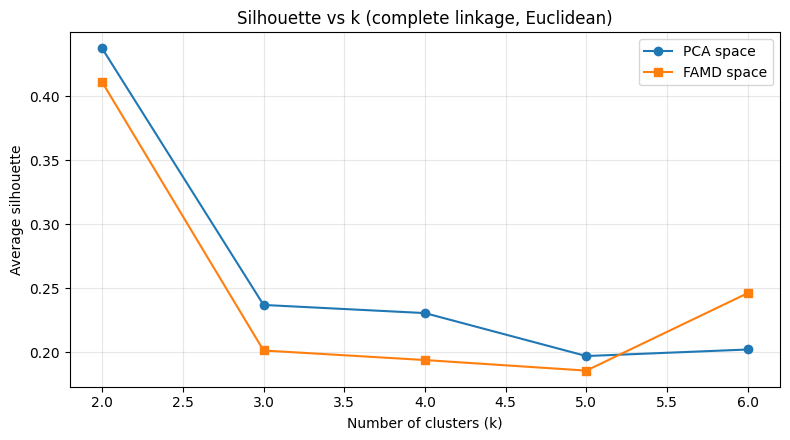

In [6]:
# --- FIG 3A: Silhouette curves for PCA and FAMD ---
plt.figure(figsize=(8, 4.5))
plt.plot(list(k_range), silhouette_pca, marker='o', label='PCA space')
plt.plot(list(k_range), silhouette_famd, marker='s', label='FAMD space')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette')
plt.title('Silhouette vs k (complete linkage, Euclidean)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig3a_silhouette.png', dpi=300)
print("Saved fig3a_silhouette.png")

Saved fig3b_cluster_profile.png


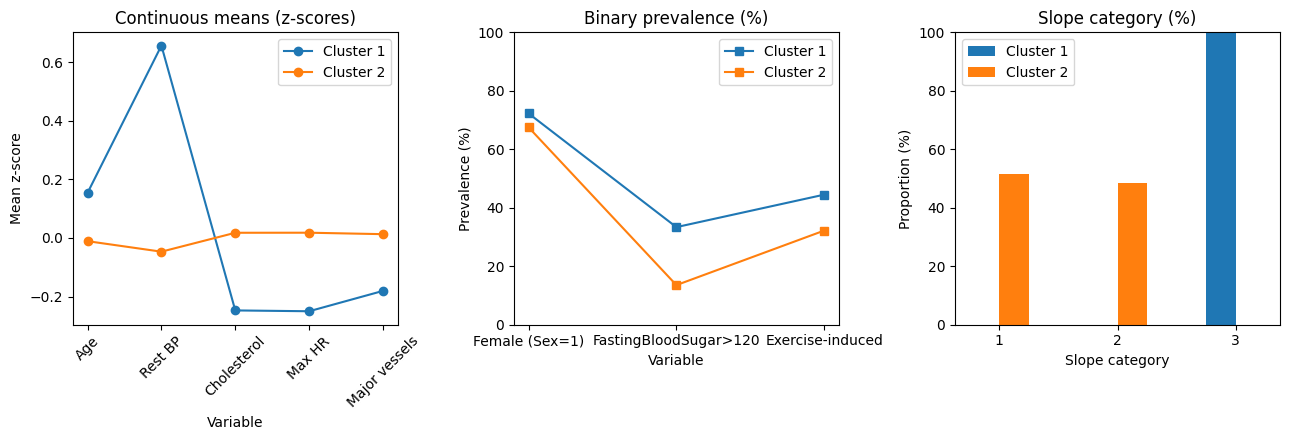

In [8]:
# --- FIG 3B: Cluster profile (means, binary prevalences, slope distribution) ---
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5))

# Panel A: continuous variables (mean z-scores)
for cluster_id, row in summary_cont.iterrows():
    axes[0].plot(cont_vars, row.values, marker='o', label=f'Cluster {cluster_id}')
axes[0].set_title('Continuous means (z-scores)')
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('Mean z-score')
axes[0].set_xticks(range(len(cont_vars)))
axes[0].set_xticklabels(['Age','Rest BP','Cholesterol','Max HR','Major vessels'], rotation=45)
axes[0].legend()

# Panel B: binary prevalences
binary_vars = ['Sex','FastingBloodSugar','ExerciseInduced']
binary_labels = ['Female (Sex=1)','FastingBloodSugar>120','Exercise-induced']
for cluster_id, row in summary_binary[binary_vars].iterrows():
    axes[1].plot(binary_labels, row.values, marker='s', label=f'Cluster {cluster_id}')
axes[1].set_title('Binary prevalence (%)')
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Prevalence (%)')
axes[1].set_ylim(0, 100)
axes[1].legend()

# Panel C: slope distribution
slope_categories = sorted(results['Slope'].unique())
bar_width = 0.25
for idx, (cluster_id, row) in enumerate(summary_slope_percent.iterrows()):
    axes[2].bar([x + idx*bar_width for x in range(len(slope_categories))],
                row.values, width=bar_width, label=f'Cluster {cluster_id}')
axes[2].set_title('Slope category (%)')
axes[2].set_xlabel('Slope category')
axes[2].set_ylabel('Proportion (%)')
axes[2].set_xticks([r + bar_width/2 for r in range(len(slope_categories))])
axes[2].set_xticklabels(slope_categories)
axes[2].set_ylim(0, 100)
axes[2].legend()

fig.tight_layout()
fig.savefig('fig3b_cluster_profile.png', dpi=300)
print("Saved fig3b_cluster_profile.png")